In [1]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline

In [2]:
df = dmba.load_data('Tayko.csv')
df = df.iloc[0:1000]
df.head


<bound method NDFrame.head of      sequence_number  US  source_a  source_c  source_b  source_d  source_e  \
0                  1   1         0         0         1         0         0   
1                  2   1         0         0         0         0         1   
2                  3   1         0         0         0         0         0   
3                  4   1         0         1         0         0         0   
4                  5   1         0         1         0         0         0   
..               ...  ..       ...       ...       ...       ...       ...   
995              996   1         0         1         0         0         0   
996              997   1         0         0         0         0         1   
997              998   1         0         0         0         1         0   
998              999   1         0         0         0         0         0   
999             1000   1         0         0         1         0         0   

     source_m  source_o  source_h

In [25]:
categorycal_field_arr = ['US','Web order','Gender=male','Address_is_res']
continuous_field_arr = ['Freq','last_update_days_ago','Address_is_res']


In [4]:
#a. 범주형 변수들에 대한 테이블을 만들고 각 범주별로 소비 금액의 평균과 표준편차를 계산하시오
for cat in categorycal_field_arr: 
    tmp = df['Spending'].groupby(df[cat]) 
    print("=====================")
    print("평균")
    print(tmp.mean())
    print("\n표준편차")
    print(tmp.std())
    print("=====================")



평균
US
0    114.256250
1    108.513095
Name: Spending, dtype: float64

표준편차
US
0    186.029796
1    201.350198
Name: Spending, dtype: float64
평균
Web order
0     87.690311
1    139.210900
Name: Spending, dtype: float64

표준편차
Web order
0    180.719540
1    218.119855
Name: Spending, dtype: float64
평균
Gender=male
0    116.956159
1    102.514395
Name: Spending, dtype: float64

표준편차
Gender=male
0    205.897881
1    192.180125
Name: Spending, dtype: float64
평균
Address_is_res
0    112.461047
1     98.502304
Name: Spending, dtype: float64

표준편차
Address_is_res
0    212.884983
1    136.901158
Name: Spending, dtype: float64


Freq
last_update_days_ago
Address_is_res


C:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\function_base.py:

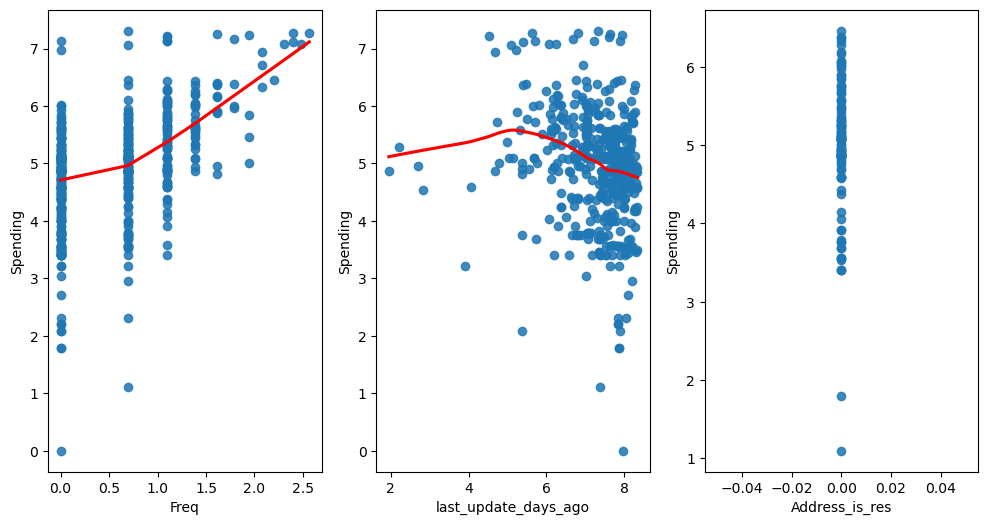

In [30]:
#b. 연속형 변수들에 대하여 산점도를 작성하여 소비금액과의 관계를 탐색하시오.
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=len(continuous_field_arr))


for i in range(len(continuous_field_arr)):
    print(continuous_field_arr[i])
    sns.scatterplot(y='Spending', x=continuous_field_arr[i], alpha=.3,data=np.log(df),ax=ax[i])
    sns.regplot(y='Spending', x=continuous_field_arr[i], lowess=True,line_kws={'color': 'red'},data=np.log(df),ax=ax[i])


In [6]:
#Q : 이 들이 선형관계가 있어보이는가
#A : 없어보입니다.

In [7]:
predictors = categorycal_field_arr+continuous_field_arr
outcome = 'Spending'

# partition data
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1) # C-1 학습데이터와 검증데이터로 나누시오.

#C-2 예측변수 6개를 사용하여 다중 선형회귀모델을 만드시오.

tayko_lm = LinearRegression() 
tayko_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', tayko_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': tayko_lm.coef_}))

#c-3 가장 많은 돈을 지출할 것 같은 구매고객의 유형은 무엇인가
#A : Address_is_res가 0이고 Freq가 높은 고객

# print performance measures

intercept  28.90074625790308
              Predictor  coefficient
0                    US   -16.560990
1             Web order    17.580054
2           Gender=male    -9.796171
3        Address_is_res   -87.559593
4                  Freq    95.886941
5  last_update_days_ago    -0.013517

Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 137.0174
     Mean Absolute Error (MAE) : 81.5420


In [23]:

regressionSummary(train_y, tayko_lm.predict(train_X))


Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 137.0174
     Mean Absolute Error (MAE) : 81.5420


In [8]:
pred_y = tayko_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, tayko_lm))
print('AIC : ', AIC_score(train_y, pred_y, tayko_lm))
print('BIC : ', BIC_score(train_y, pred_y, tayko_lm))

adjusted r2 :  0.5191116045943522
AIC :  7622.855326565702
BIC :  7658.030763807431


In [9]:
# Use predict() to make predictions on a new set
tayko_lm_pred = tayko_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': tayko_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - tayko_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, tayko_lm_pred)

      Predicted  Actual     Residual
507   68.040290     229   160.959710
818   51.095515       0   -51.095515
452   75.964195     137    61.035805
368  290.331238    1353  1062.668762
242   60.688937       0   -60.688937
929  196.075766     266    69.924234
262  196.255517     210    13.744483
810    0.943491       0    -0.943491
318  357.706563     204  -153.706563
49   128.300336       0  -128.300336
446   77.827942      54   -23.827942
142   76.001547     129    52.998453
968   75.732874     114    38.267126
345  179.070782     248    68.929218
971   66.234068       0   -66.234068
133   65.936704       0   -65.936704
104   83.400106     164    80.599894
6     96.306231       0   -96.306231
600  600.853058     150  -450.853058
496  -14.041240       0    14.041240

Regression statistics

               Mean Error (ME) : 4.0080
Root Mean Squared Error (RMSE) : 151.5463
     Mean Absolute Error (MAE) : 87.7414


1.0


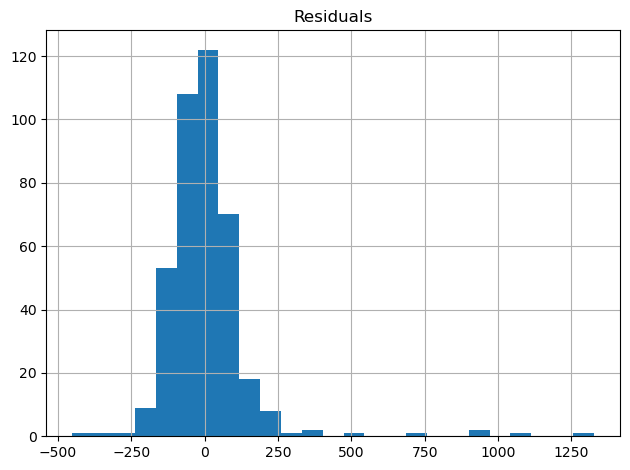

In [10]:
tayko_lm_pred = tayko_lm.predict(valid_X)
all_residuals = valid_y - tayko_lm_pred

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

In [11]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

   n     r2adj          AIC  Address_is_res  Freq  Gender=male     US  Web order  \
0  1  0.486727  7656.996856           False  True        False  False      False   
1  2  0.513277  7626.124963            True  True        False  False      False   
2  3  0.518118  7621.121933            True  True        False  False      False   
3  4  0.519209  7620.753635            True  True        False  False       True   
4  5  0.519309  7621.619630            True  True        False   True       True   
5  6  0.519112  7622.855327            True  True         True   True       True   

   last_update_days_ago  
0                 False  
1                 False  
2                  True  
3                  True  
4                  True  
5                  True  


In [12]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables) #c-4 후진제거 방법을 사용한다면 어떠한 예측변수가 가장 먼저 탈락하겠는가
#A : Gender=male 변수가 가장 먼저 삭제된다.

Variables: US, Web order, Gender=male, Address_is_res, Freq, last_update_days_ago
Start: score=7622.86
Step: score=7621.62, remove Gender=male
Step: score=7620.75, remove US
Step: score=7620.75, remove None
['Web order', 'Address_is_res', 'Freq', 'last_update_days_ago']


In [13]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

               Mean Error (ME) : 3.6631
Root Mean Squared Error (RMSE) : 151.4687
     Mean Absolute Error (MAE) : 87.9480


In [14]:
from sklearn.metrics import mean_absolute_error

mae_pred = mean_absolute_error(pred_y, train_y) 

mae_pred

81.54195057532786

In [15]:
#test_x = valid_X[0]
#test_y = valid_y[0]
test_x = valid_X[:1]
test_y = valid_y[:1]

tayko_lm_pred = tayko_lm.predict(test_x)

result = pd.DataFrame({'Predicted': tayko_lm_pred, 'Actual': test_y,
                       'Residual': test_y - tayko_lm_pred})
print(result.head())
#c-5 검증ㅇ데이터의 첫번째 구매데이터를 이용하여 예측값과 예측오차 계산



     Predicted  Actual   Residual
507   68.04029     229  160.95971


In [16]:
import statsmodels.api as sm;
mlr = sm.OLS(df[outcome],df[predictors])
result_mlr = mlr.fit()
print(result_mlr.summary())
#address_is_res와 freq의 p-value가 매우 낮으므로 feature로 선정할 만 하다




                                 OLS Regression Results                                
Dep. Variable:               Spending   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.601
Method:                 Least Squares   F-statistic:                              251.7
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                   1.57e-195
Time:                        16:37:57   Log-Likelihood:                         -6381.5
No. Observations:                1000   AIC:                                  1.278e+04
Df Residuals:                     994   BIC:                                  1.280e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [24]:
print("정확도 : ",tayko_lm.score(train_X, train_y))


정확도 :  0.5239285167353103


<Axes: >

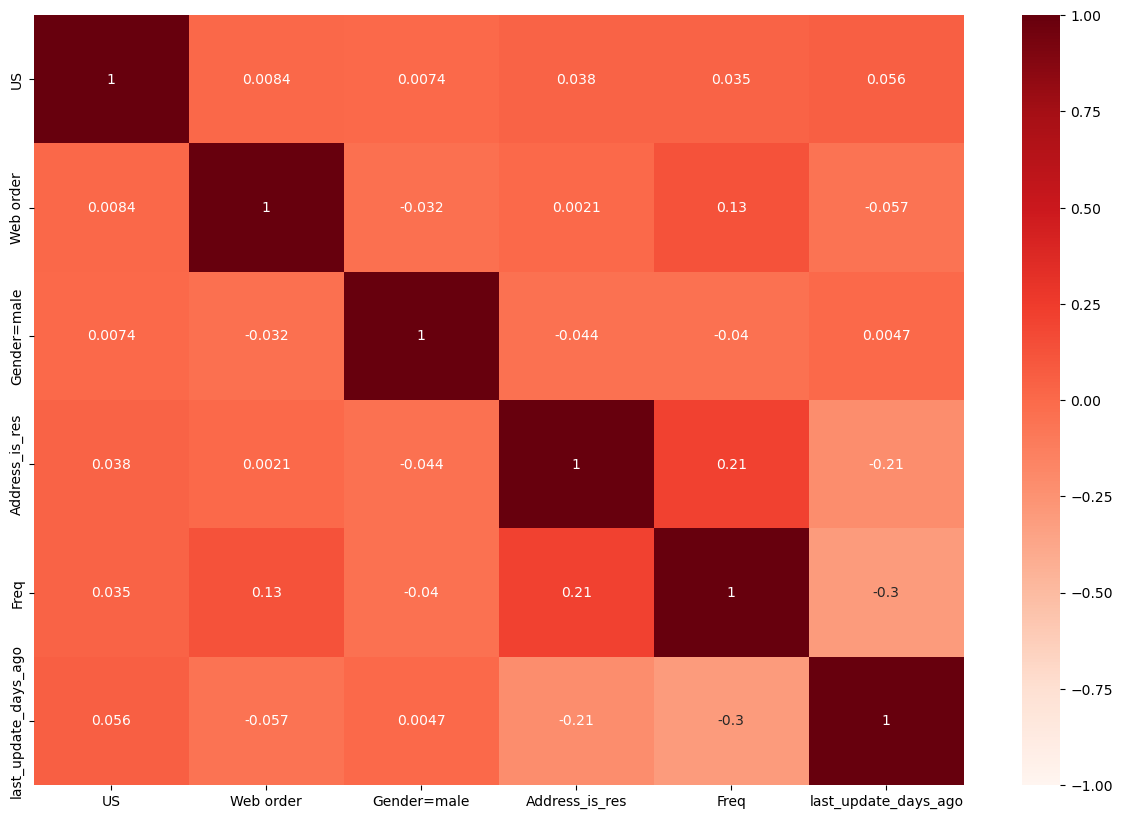

In [17]:
X = df[predictors]
y = df[outcome]

plt.rcParams['figure.figsize']=(15,10)
sns.heatmap(X.corr(),
          annot=True,
          cmap='Reds',
          vmin=-1,vmax=1)



In [19]:
#X = df[predictors]
#y = df[outcome]
#np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose()), y)

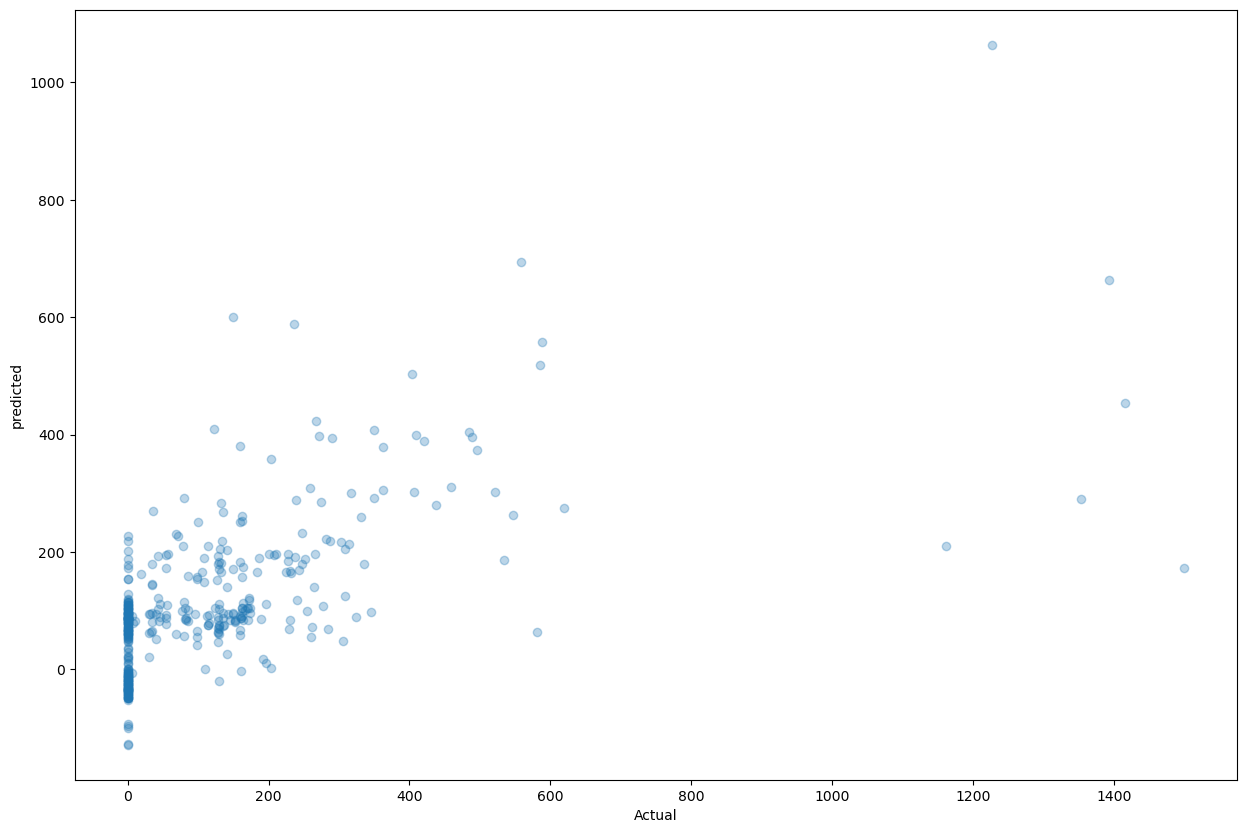

In [20]:
pred_y = tayko_lm.predict(valid_X)

plt.scatter(valid_y,pred_y,alpha=.3)
plt.xlabel("Actual")
plt.ylabel("predicted")
plt.show()

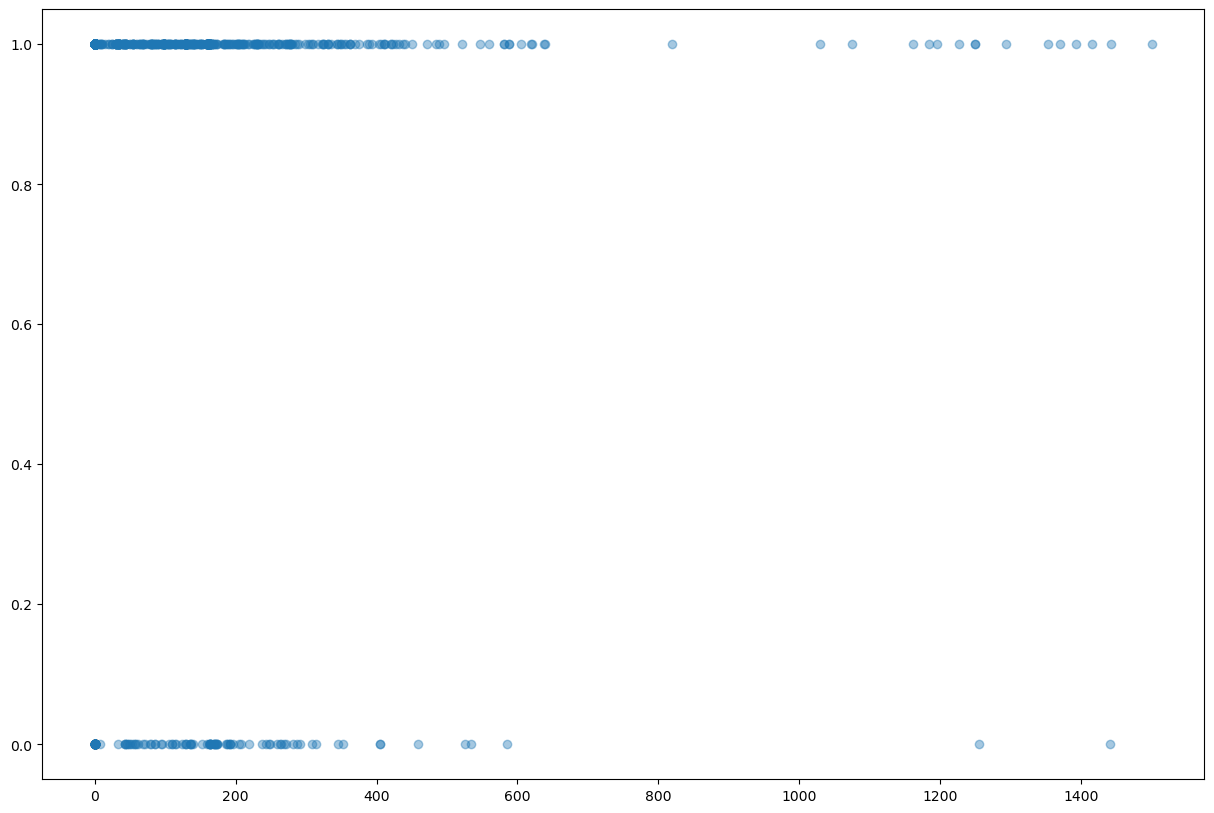

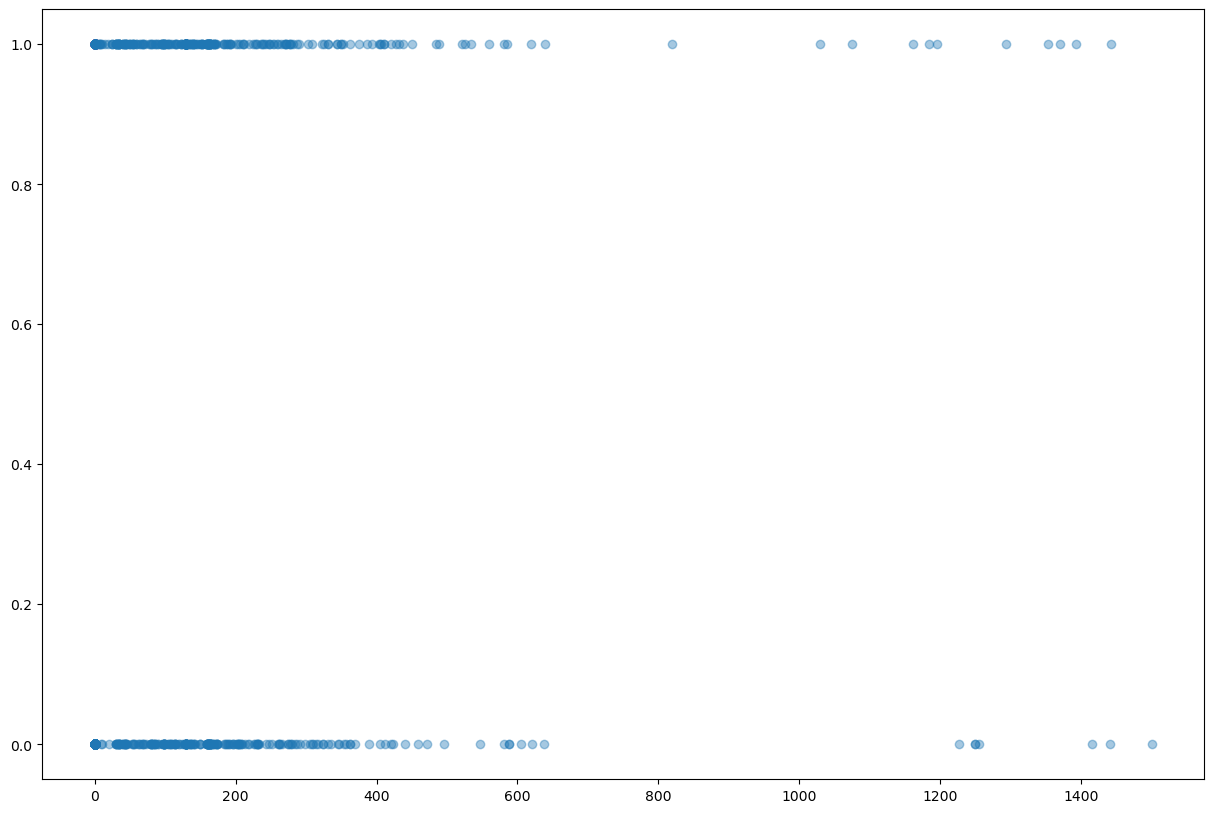

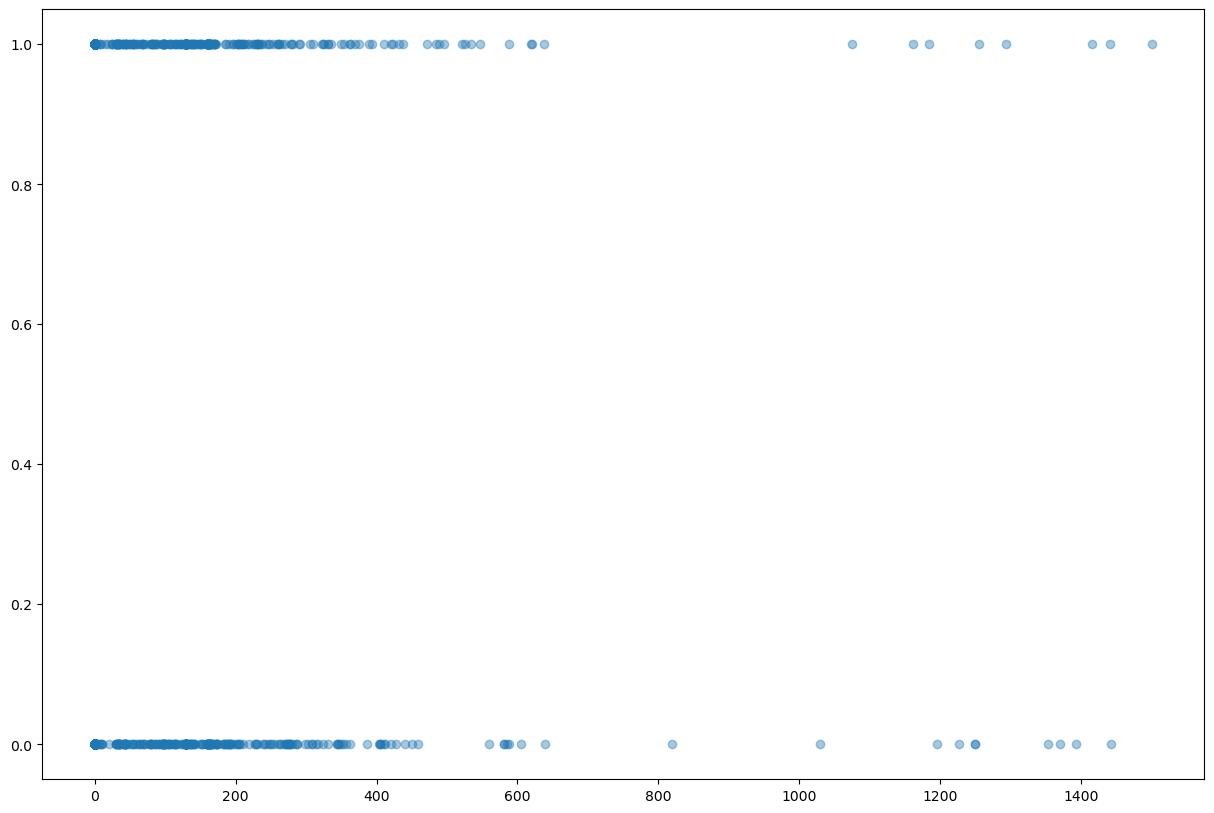

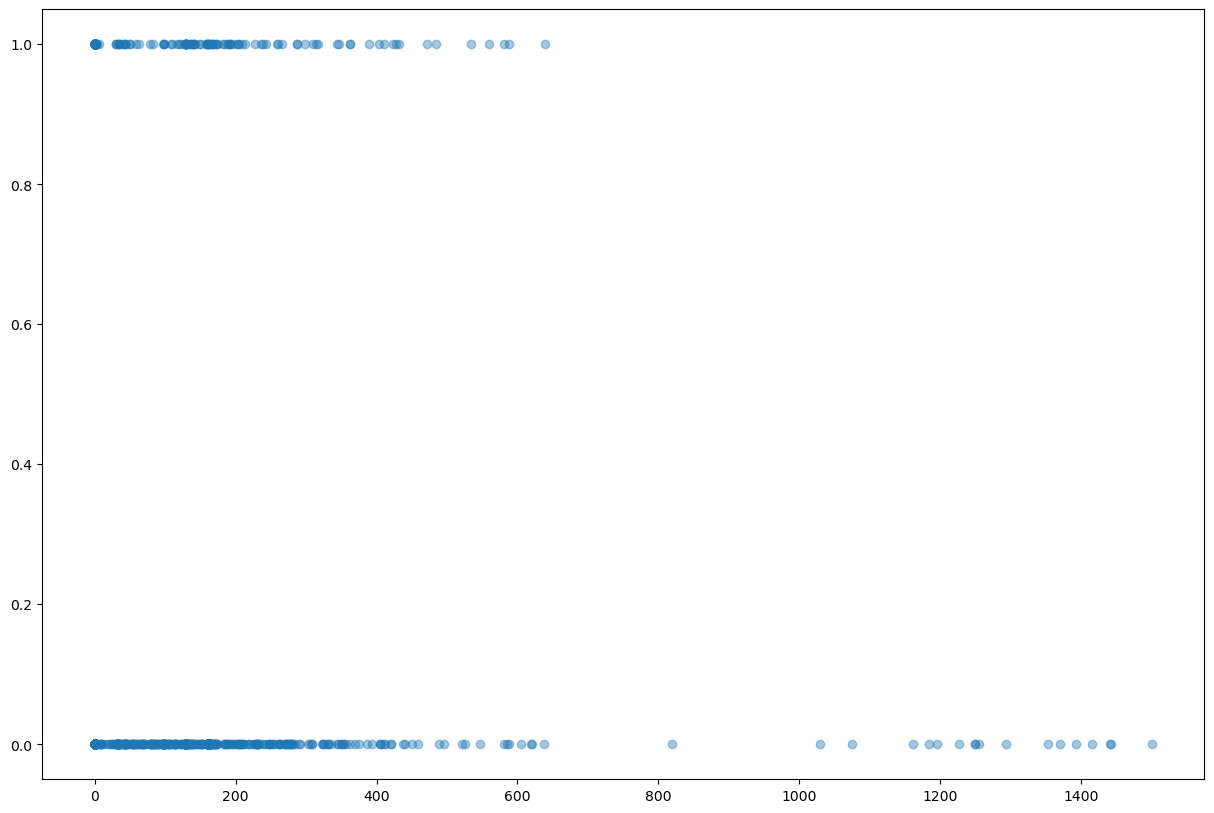

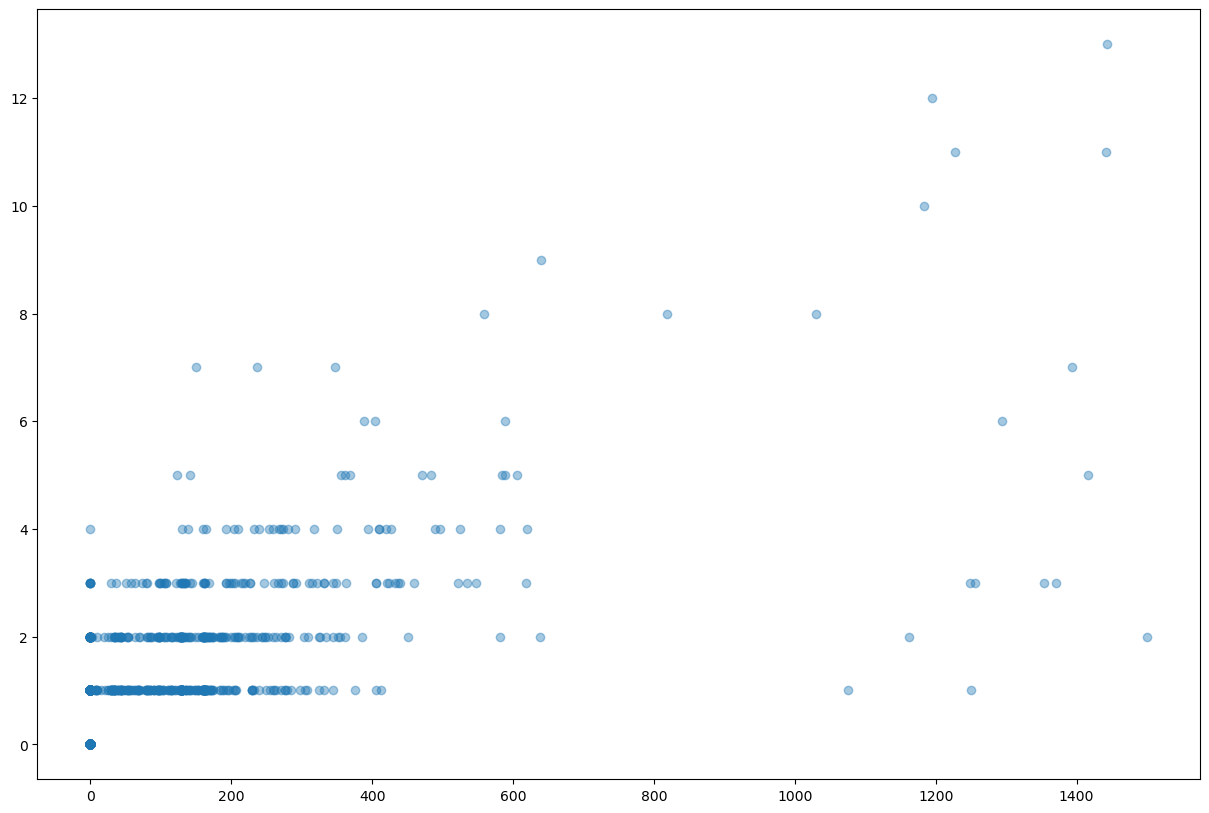

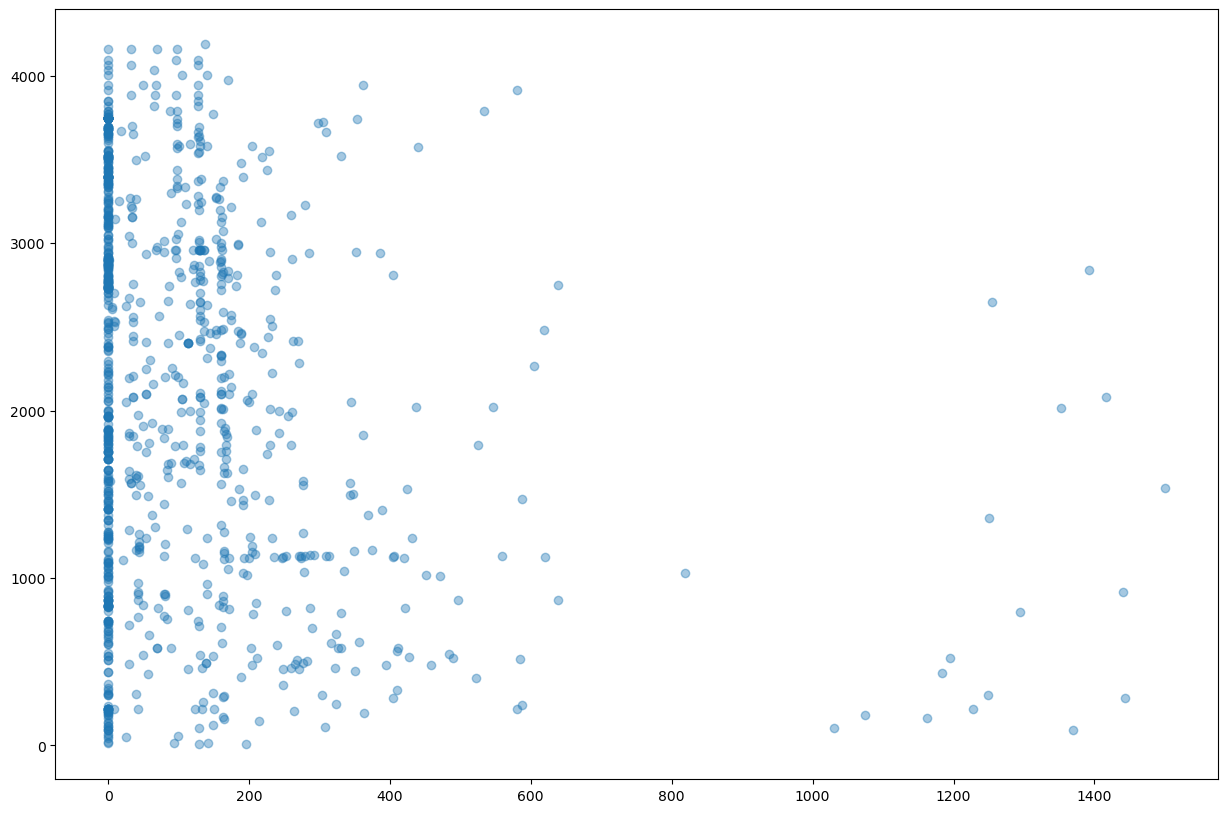

In [21]:
for prd in predictors:
    plt.scatter(df[outcome], df[prd], alpha=0.4)
    plt.show()

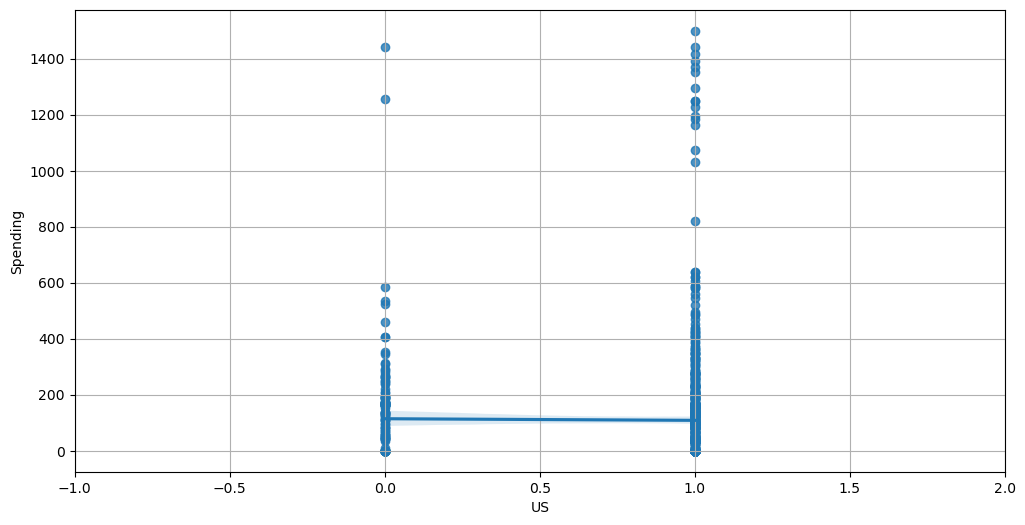

-5.743154761904741 114.25625000000001
108.51309523809527


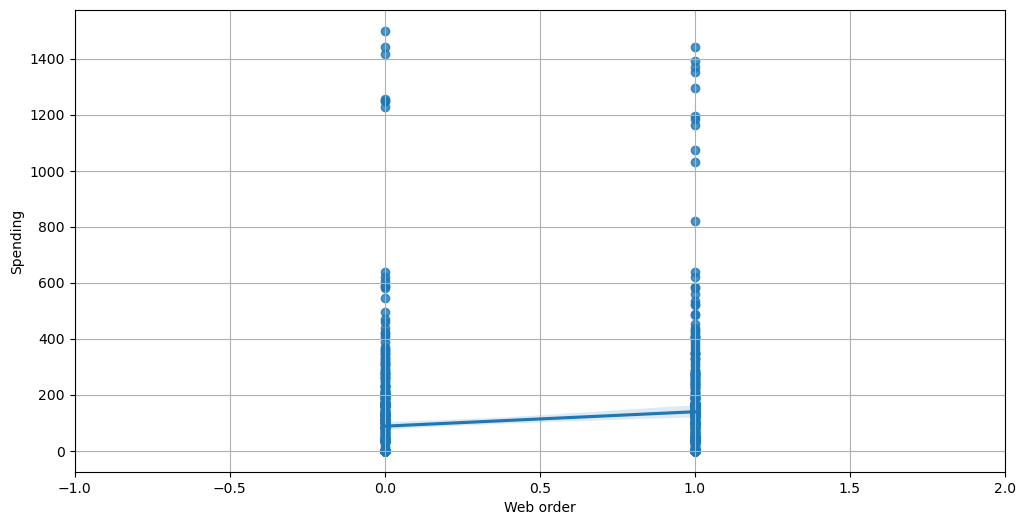

51.520589055248465 87.69031141868516
139.21090047393363


SyntaxError: invalid syntax (<unknown>, line 1)

In [22]:
import numpy as np
from statsmodels.formula.api import ols

for prd in predictors:
    #pyplot과 seaborn으로 회귀그래프 
    plt.rcParams["figure.figsize"] = (12, 6)
    sns.regplot(x=prd, y=outcome, data=df)
    plt.xlim(df[prd].min()-1, df[prd].max()+1)
    plt.grid()
    plt.show()

    z=np.polyfit(df[prd], df[outcome], 1) # 기울기와 절편 확인
    f=np.poly1d(z) # f(x): f함수에 x값을 넣으면 y값을 계산해 줌
    print(z[0], z[1])
    print(f(1))

    #statsmodel을 통해 회귀식의 회귀계수(기울기, 절편) 확인
    ols('{0} ~ Spending'.format(prd), data=df).fit().summary()